In [ ]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import library
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from numpy import savetxt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dongsi.csv to Dongsi.csv


In [ ]:
data=read_csv("Dongsi.csv")
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,NNW,5.7
1,2,2013,3,1,1,4.0,4.0,3.0,16.0,300.0,88.0,-0.7,1025.1,-22.1,0.0,NW,3.9
2,3,2013,3,1,2,7.0,7.0,NaN,17.0,300.0,60.0,-1.2,1025.3,-24.6,0.0,NNW,5.3
3,4,2013,3,1,3,3.0,3.0,5.0,18.0,NaN,NaN,-1.4,1026.2,-25.5,0.0,N,4.9
4,5,2013,3,1,4,3.0,3.0,7.0,NaN,200.0,84.0,-1.9,1027.1,-24.5,0.0,NNW,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,16.0,51.0,3.0,29.0,400.0,73.0,12.5,1013.5,-16.2,0.0,NW,2.4
35060,35061,2017,2,28,20,18.0,45.0,3.0,43.0,500.0,54.0,11.6,1013.6,-15.1,0.0,WNW,0.9
35061,35062,2017,2,28,21,23.0,58.0,5.0,61.0,700.0,28.0,10.8,1014.2,-13.3,0.0,NW,1.1
35062,35063,2017,2,28,22,23.0,53.0,9.0,75.0,900.0,15.0,10.5,1014.4,-12.9,0.0,NNW,1.2


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('Dongsi.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])

In [ ]:
dataset.drop("No", axis=1, inplace=True)

In [ ]:
dataset=dataset.fillna(method="pad")

In [ ]:
dataset.isnull().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

In [ ]:
dataset_columns = dataset.columns.tolist()
dataset_columns

['PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'wd',
 'WSPM']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = dataset.values
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
values = values.astype('float32')
values[:,10]

array([6., 7., 6., ..., 7., 6., 5.], dtype=float32)

In [ ]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [ ]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [ ]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (35060, 1)
X (35060, 4, 12)


In [ ]:
#Splitting the dataset
n_train = 24*365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (26300, 4, 12)
X_test (8760, 4, 12)
Y_train (26300, 1)
Y_test (8760, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')

In [ ]:
history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size = 64, verbose=1)

Epoch 1/100
411/411 [==============================] - 3s 4ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 2/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 3/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 4/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 6/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 8/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0019 - val_lo

In [ ]:
from keras.models import load_model
model_cnn.save('AirPollutionCNN.h5')

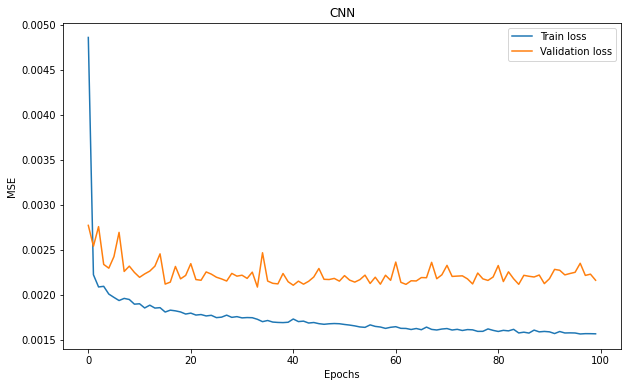

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("CNN")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
plt.savefig('graph_CNN.png')

In [ ]:
RMSE1=[]
RMAE1=[]
MAPE1=[]
R22=[]

for i in range(40, 181, 5):
  Y_pred = model_cnn.predict(X_test[:i,:])
  print(Y_pred.shape)
  #print(Y_pred)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:i,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_tested = scaler.inverse_transform(Y_tested)
  Y_predicted = Y_predicted[:,0:1]
  Y_tested = Y_tested[:i,0:1]
  mse = mean_squared_error(Y_tested, Y_predicted)
  rmse = np.sqrt(mse)
  print("RMSE at %s = %s" % (i, rmse))
  RMSE1=np.append(RMSE1,rmse)
  mae = mean_absolute_error(Y_tested, Y_predicted)
  rmae = np.sqrt(mae)
  RMAE1=np.append(RMAE1,rmae)
  print("RMAE at %s = %s" % (i, rmae))
  mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
  print("MAPE at %s = %s" % (i, mape))
  MAPE1=np.append(MAPE1,mape)
  #R2 score
  R2 = r2_score( Y_predicted, Y_tested)
  print("R2 at %s = %s" % (i, R2))
  R22=np.append(R22,R2)

2/2 [==============================] - 0s 7ms/step
(40, 1)
RMSE at 40 = 10.08208
RMAE at 40 = 2.8526392
MAPE at 40 = 1.8697417
R2 at 40 = 0.628780007804489
2/2 [==============================] - 0s 12ms/step
(45, 1)
RMSE at 45 = 9.869317
RMAE at 45 = 2.83076
MAPE at 45 = 1.6699448
R2 at 45 = 0.8709899218675357
2/2 [==============================] - 0s 8ms/step
(50, 1)
RMSE at 50 = 12.98675
RMAE at 50 = 3.1550722
MAPE at 50 = 1.5256613
R2 at 50 = 0.8566784690020057
2/2 [==============================] - 0s 9ms/step
(55, 1)
RMSE at 55 = 13.823295
RMAE at 55 = 3.2901332
MAPE at 55 = 1.406135
R2 at 55 = 0.8539645598804338
2/2 [==============================] - 0s 18ms/step
(60, 1)
RMSE at 60 = 14.9507475
RMAE at 60 = 3.364194
MAPE at 60 = 1.3118302
R2 at 60 = 0.8522648116134971
3/3 [==============================] - 0s 6ms/step
(65, 1)
RMSE at 65 = 16.424994
RMAE at 65 = 3.497722
MAPE at 65 = 1.2337372
R2 at 65 = 0.811929088766771
3/3 [==============================] - 0s 5ms/step
(70, 1)


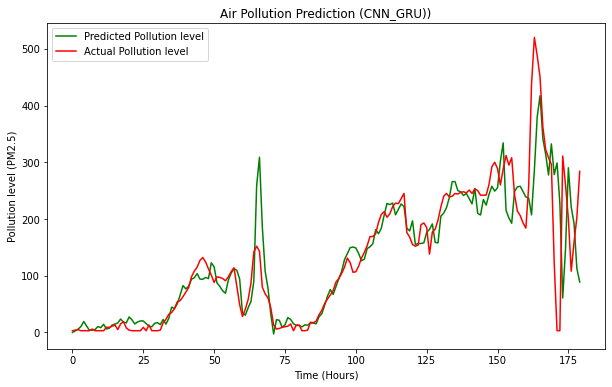

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted, color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (CNN_GRU))")
plt.xlabel("Time (Hours)")
plt.ylabel("Pollution level (PM2.5)")
plt.legend()
plt.show()
plt.savefig('graphCNN.png')

In [ ]:
savetxt('Predict_LSTM.csv', Y_predicted, delimiter=',')

In [ ]:
savetxt('Test_LSTM.csv', Y_test, delimiter=',')